try:
    import cupy as cp
    using_cupy = True
except:
    import numpy as cp
    using_cupy = False
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from tqdm import tqdm

# Parameters for the 3D grid
Lx, Ly = 2.0, 2.0  # Dimensions of the individual squares
Lz = Ly / 10  # Depth is 1/10 the length of the smaller side (z dimension)
Nx, Ny = 120, 120  # Number of points in x, y, and z directions for each square
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Step sizes
alpha1 = 0.3  # Thermal diffusivity for areas with zero in the matrix
alpha2 = 3.0  # Thermal diffusivity for areas with one in the matrix
beta = 0.005  # Convection coefficient
sigma = 5.67e-8  # Stefan-Boltzmann constant for radiation
epsilon = 0.85

T_ambient = 270  # Ambient temperature for radiation term
T_laser = T_ambient + 40
T_amplitude =T_laser - T_ambient 

snapshot_N = 4  # Number of snapshots to save
time_steps_between_snapshots = 1

Nt = time_steps_between_snapshots * snapshot_N  # Number of time steps
dt_times_Nt = Nt * 0.01
dt = dt_times_Nt / Nt  # Time step size

def rotate_90(matrix):
    # Step 1: Transpose the matrix
    transposed = np.transpose(matrix)
    
    # Step 2: Reverse the order of elements in each row
    rotated = np.array([row[::-1] for row in transposed])
    
    return rotated
    
# Provide a matrix with 0s and 1s for different diffusivity regions, 1 is alpha2
# visual_matrix = np.array([
#     [1,1,0,0,0],
#     [1,1,1,0,0],
#     [0,1,1,1,0],
#     [0,0,1,1,1],
#     [0,0,0,1,1]
# ])

visual_matrix = np.array([
                          [[0,1],
                          [0,1]]
                         ,
                         
                          [[0,1],
                          [0,1]]
                         ,
                         
                          [[0,1],
                          [0,1]]
                         ]) #Inner x, middle y, outer z [z, y, x]
#swap to order [x, y, z]

visual_matrix_swapped = visual_matrix.transpose(2, 1, 0)
print(visual_matrix_swapped)



# Reverse each row (flip horizontally)
#visual_matrix = rotate_90(((visual_matrix)))
#visual_matrix = visual_matrix[:, ::-1]

# Reverse each row (flip vertically)
#visual_matrix = visual_matrix[::+1, :]

## Transpose the result
#A_transposed = A_flipped.T
diffusivity_matrix = visual_matrix

total_Nx, total_Ny = Nx, Ny

# Create the initial temperature distribution using CuPy
x = cp.linspace(0, Lx, total_Nx)
y = cp.linspace(0, Ly, total_Ny)
#z = cp.linspace(0, Lz, total_Nz)
X, Y = cp.meshgrid(x, y, indexing='ij')

# Initial temperature distribution
temperature = cp.zeros((total_Nx, total_Ny)) + T_ambient
#center_square_mask = (abs(X - Lx / 2) < Lx / 16)& (abs(Y - Ly / 2) < Ly / 16)

def get_rectangular_mask(center, lengths):
    mask = (abs(X - center[0]) < lengths[0])& (abs(Y - center[1]) < lengths[1])
    return mask

def get_circular_mask(center, radius):
    # Compute the distance from each point to the center
    distance = (X - center[0])**2 + (Y - center[1])**2
    # Create a mask where the distance is less than or equal to the radius squared
    mask = distance <= radius**2
    return mask



def apply_gaussian_in_rectangular_mask(sigma_x =  Lx/8, sigma_y = Ly/8, mu_x = Lx/2,  mu_y = Ly/2):
    # Create a meshgrid for the coordinates
    X, Y = cp.meshgrid(cp.linspace(0, Lx, total_Nx), cp.linspace(0, Ly, total_Ny), indexing='ij')
    
    # Gaussian distribution
    gaussian = T_amplitude * cp.exp(-((X - mu_x)**2 / (2 * sigma_x**2) + (Y - mu_y)**2 / (2 * sigma_y**2)))
    
    # Ensure the mask and temperature are compatible
    temperature = gaussian
    
    return temperature
    
    
initial_dist = "gaussian"

if initial_dist == "circle":
    temperature[ get_circular_mask((Lx / 2, Ly /2), (Ly / 3)) ] += T_amplitude
elif initial_dist == "square":
    temperature[ get_rectangular_mask((Lx / 2, Ly /2), (Ly / 4, Ly / 4)) ] += T_amplitude
elif initial_dist == "gaussian":
    temperature += apply_gaussian_in_rectangular_mask()
    
#temperature[ get_rectangular_mask((Lx / 2, Ly /2), (Lx / 16, Ly / 16)) ] = T_laser  # Source in the center
#temperature[ get_circular_mask((Lx / 2, Ly /2), (Ly / 3)) ] = T_laser  # Source in the center

def set_borders_to_ambient_nd(temperature):
    # Get the shape of the temperature array
    shape = temperature.shape
    
    # Create a slice object for each dimension that selects all elements in the inner part (not on the borders)
    slices = tuple(slice(1, dim_size-1) if dim_size > 1 else slice(None) for dim_size in shape)
    
    # Set borders: first and last indices along each dimension
    temperature[(slice(0, 1),) * len(shape)] = T_ambient  # First element in all dimensions
    temperature[(slice(-1, None),) * len(shape)] = T_ambient  # Last element in all dimensions
    
    # Apply borders for each dimension (first and last index in every dimension)
    for dim in range(len(shape)):
        # First index along `dim`
        slices = [slice(None)] * len(shape)
        slices[dim] = slice(0, 1)  # set the first index for this dimension
        temperature[tuple(slices)] = T_ambient
        
        # Last index along `dim`
        slices[dim] = slice(-1, None)  # set the last index for this dimension
        temperature[tuple(slices)] = T_ambient

    return temperature
    

#print(f"{=}")
print(f"{temperature.shape=}")
# Create a function to set alpha based on the diffusivity matrix
def create_alpha_variable(matrix, alpha1, alpha2):
    # Create the 3D coordinate grids using meshgrid
    X, Y = cp.meshgrid(x, y, indexing='ij')
    
    # Initialize alpha with the default value alpha1
    alpha = cp.full((Nx, Ny), alpha1)
    
    # Iterate over the diffusivity matrix to set alpha2 in the appropriate regions
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            if matrix[row, col] == 1:
                # Calculate the range for this block in the X and Y directions
                x_start, x_end = col * Lx / matrix.shape[0], (col + 1) * Lx / matrix.shape[0]
                y_start, y_end = row * Ly / matrix.shape[1], (row + 1) * Ly / matrix.shape[1]

                # Create a mask for the region where alpha should be alpha2
                mask = (X >= x_start) & (X <= x_end) & (Y >= y_start) & (Y <= y_end)
                
                # Set alpha2 in the selected region
                alpha[mask] = alpha2
    
    return alpha

# Define alpha based on the matrix
alpha_variable = create_alpha_variable(diffusivity_matrix, alpha1, alpha2)
print(f"{alpha_variable=}")
print(f"{alpha_variable.shape=}")


# Conduction term (using finite differences)
def conduction_term(alpha, temperature):
    dTdx = (cp.roll(temperature, -1, axis=0) - temperature) / dx
    dTdy = (cp.roll(temperature, -1, axis=1) - temperature) / dy
    return alpha * (dTdx + dTdy)

# Convection term (simplified to a uniform velocity in the x-direction)
def convection_term(temperature):
    velocity = cp.array([beta, beta])  # velocity in x-direction
    dTdx = (cp.roll(temperature, -1, axis=0) - temperature) / dx
    return velocity[0] * dTdx  # Only considering x-direction for simplicity

# Radiation term (using the Stefan-Boltzmann law)
def radiation_term(temperature):
    # Create a mask for the region where alpha should be alpha2
    mask = (temperature > T_laser*1.1)
    temperature[mask] = T_laser
    mask = (temperature < T_ambient* 0.9)
    temperature[mask] = T_ambient
    return -4 * epsilon * sigma * (temperature**4 - T_ambient**4)

# Source term (square wave pattern)
def source_term(type="square"):
    source = cp.zeros((total_Nx, total_Ny))
    
    if type == "gaussian":
        mu_x = Lx / 2  # Mean in the x-direction (center of the Gaussian)
        mu_y = Ly / 2  # Mean in the y-direction (center of the Gaussian)
        sigma = 0.1 * Lx  # Standard deviation (spread of the Gaussian)
        r = min(Lx, Ly) / 4  # Radius of the circular mask (controls the size of the circle)
        
        # Create a circular mask (distance from the center within radius `r`)
        distance_from_center = np.sqrt((X - mu_x)**2 + (Y - mu_y)**2)
        circular_mask = distance_from_center <= r
        
        # Apply the Gaussian function within the circular mask
        gaussian = T_amplitude * np.exp(-((X - mu_x)**2 + (Y - mu_y)**2) / (2 * sigma**2)) 
        
        # Add the Gaussian term to the source where the circular mask is true
        source[circular_mask] += gaussian[circular_mask]
        
    if type == "square":
        mask = (X < Lx*3/4) & (Y < Ly*3/4)& (X > Lx*1/4) & (Y > Ly*1/4)
        source[mask] += T_amplitude 
    if type == "none":
        mask = (X < Lx*3//4) & (Y < Ly*3/4)& (X > Lx*1//4) & (Y > Ly*1/4)
        source[mask] += 0
    return source

# Select source type
source_name = "square"
selected_source = source_term(type=source_name)

# Time-stepping loop
snapshots = []
time = 0.0

for n in tqdm(range(Nt), desc="Solving heat equation"):
    time += dt
    # Compute temperature update
    conduction = conduction_term(alpha_variable, temperature)
    
    convection = convection_term(temperature)
    radiation = radiation_term(temperature)
    source = selected_source

    # Update the temperature field
    temperature += dt * (conduction + convection + radiation + source)
    temperature = set_borders_to_ambient_nd(temperature)
    
    # Save snapshots
    if n % (Nt // snapshot_N) == 0:
        snap = temperature[:, :]
        if using_cupy: snap = snap.get()
            
        snapshots.append(snap)  # Save the middle slice for visualization

# Create a 3D plot for the snapshots
x_grid = np.linspace(0,  Lx, total_Nx)
y_grid = np.linspace(0,  Ly, total_Ny)

# Create a 3D plot for the snapshots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X_slice = X[:, :]
Y_slice = Y[:, :]

if using_cupy:
    X_slice = X_slice.get()
    Y_slice = Y_slice.get()
    
surface = ax.plot_surface(X_slice, Y_slice, snapshots[0], cmap='hot')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

# Update function for the animation
def update_3d_plot(frame):
    ax.clear()
    surface = ax.plot_surface(X_slice, Y_slice, snapshots[frame], cmap='hot')
    ax.set_zlim(T_ambient, T_laser)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Temperature')
    ax.set_title(f'T = {frame * Nt // snapshot_N * dt:.2f} s. $\\alpha_1$ = {alpha1}. $\\alpha_2$ = {alpha2}. Source: {source_name}. Initial dist.: {initial_dist}')

    return ax,

# Create animation
ani = animation.FuncAnimation(fig, update_3d_plot, frames=len(snapshots), interval=300)
ani.save('heat_equation_3D.gif', writer='pillow')

#plt.show()


from IPython.display import Image

# Provide the file path to the local GIF
Image(filename='heat_equation_3D.gif')


# Reverse each row (flip horizontally)
visual_matrix = rotate_90(((visual_matrix)))
#visual_matrix = visual_matrix[:, ::-1]

# Reverse each row (flip vertically)
#visual_matrix = visual_matrix[::+1, :]

## Transpose the result
#A_transposed = A_flipped.T
diffusivity_matrix = visual_matrix

total_Nx, total_Ny = Nx, Ny

# Create the initial temperature distribution using CuPy
x = cp.linspace(0, Lx, total_Nx)
y = cp.linspace(0, Ly, total_Ny)
#z = cp.linspace(0, Lz, total_Nz)
X, Y = cp.meshgrid(x, y, indexing='ij')

# Initial temperature distribution
temperature = cp.zeros((total_Nx, total_Ny)) + T_ambient
#center_square_mask = (abs(X - Lx / 2) < Lx / 16)& (abs(Y - Ly / 2) < Ly / 16)

def get_rectangular_mask(center, lengths):
    mask = (abs(X - center[0]) < lengths[0])& (abs(Y - center[1]) < lengths[1])
    return mask

def get_circular_mask(center, radius):
    # Compute the distance from each point to the center
    distance = (X - center[0])**2 + (Y - center[1])**2
    # Create a mask where the distance is less than or equal to the radius squared
    mask = distance <= radius**2
    return mask



def apply_gaussian_in_rectangular_mask(sigma_x =  Lx/8, sigma_y = Ly/8, mu_x = Lx/2,  mu_y = Ly/2):
    # Create a meshgrid for the coordinates
    X, Y = cp.meshgrid(cp.linspace(0, Lx, total_Nx), cp.linspace(0, Ly, total_Ny), indexing='ij')
    
    # Gaussian distribution
    gaussian = T_amplitude * cp.exp(-((X - mu_x)**2 / (2 * sigma_x**2) + (Y - mu_y)**2 / (2 * sigma_y**2)))
    
    # Ensure the mask and temperature are compatible
    temperature = gaussian
    
    return temperature
    
    
initial_dist = "gaussian"

if initial_dist == "circle":
    temperature[ get_circular_mask((Lx / 2, Ly /2), (Ly / 3)) ] += T_amplitude
elif initial_dist == "square":
    temperature[ get_rectangular_mask((Lx / 2, Ly /2), (Ly / 4, Ly / 4)) ] += T_amplitude
elif initial_dist == "gaussian":
    temperature += apply_gaussian_in_rectangular_mask()
    
#temperature[ get_rectangular_mask((Lx / 2, Ly /2), (Lx / 16, Ly / 16)) ] = T_laser  # Source in the center
#temperature[ get_circular_mask((Lx / 2, Ly /2), (Ly / 3)) ] = T_laser  # Source in the center

def set_borders_to_ambient_nd(temperature):
    # Get the shape of the temperature array
    shape = temperature.shape
    
    # Create a slice object for each dimension that selects all elements in the inner part (not on the borders)
    slices = tuple(slice(1, dim_size-1) if dim_size > 1 else slice(None) for dim_size in shape)
    
    # Set borders: first and last indices along each dimension
    temperature[(slice(0, 1),) * len(shape)] = T_ambient  # First element in all dimensions
    temperature[(slice(-1, None),) * len(shape)] = T_ambient  # Last element in all dimensions
    
    # Apply borders for each dimension (first and last index in every dimension)
    for dim in range(len(shape)):
        # First index along `dim`
        slices = [slice(None)] * len(shape)
        slices[dim] = slice(0, 1)  # set the first index for this dimension
        temperature[tuple(slices)] = T_ambient
        
        # Last index along `dim`
        slices[dim] = slice(-1, None)  # set the last index for this dimension
        temperature[tuple(slices)] = T_ambient

    return temperature
    

#print(f"{=}")
print(f"{temperature.shape=}")
# Create a function to set alpha based on the diffusivity matrix
def create_alpha_variable(matrix, alpha1, alpha2):
    # Create the 3D coordinate grids using meshgrid
    X, Y = cp.meshgrid(x, y, indexing='ij')
    
    # Initialize alpha with the default value alpha1
    alpha = cp.full((Nx, Ny), alpha1)
    
    # Iterate over the diffusivity matrix to set alpha2 in the appropriate regions
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            if matrix[row, col] == 1:
                # Calculate the range for this block in the X and Y directions
                x_start, x_end = col * Lx / matrix.shape[0], (col + 1) * Lx / matrix.shape[0]
                y_start, y_end = row * Ly / matrix.shape[1], (row + 1) * Ly / matrix.shape[1]

                # Create a mask for the region where alpha should be alpha2
                mask = (X >= x_start) & (X <= x_end) & (Y >= y_start) & (Y <= y_end)
                
                # Set alpha2 in the selected region
                alpha[mask] = alpha2
    
    return alpha

# Define alpha based on the matrix
alpha_variable = create_alpha_variable(diffusivity_matrix, alpha1, alpha2)
print(f"{alpha_variable=}")
print(f"{alpha_variable.shape=}")


# Conduction term (using finite differences)
def conduction_term(alpha, temperature):
    dTdx = (cp.roll(temperature, -1, axis=0) - temperature) / dx
    dTdy = (cp.roll(temperature, -1, axis=1) - temperature) / dy
    return alpha * (dTdx + dTdy)

# Convection term (simplified to a uniform velocity in the x-direction)
def convection_term(temperature):
    velocity = cp.array([beta, beta])  # velocity in x-direction
    dTdx = (cp.roll(temperature, -1, axis=0) - temperature) / dx
    return velocity[0] * dTdx  # Only considering x-direction for simplicity

# Radiation term (using the Stefan-Boltzmann law)
def radiation_term(temperature):
    # Create a mask for the region where alpha should be alpha2
    mask = (temperature > T_laser*1.1)
    temperature[mask] = T_laser
    mask = (temperature < T_ambient* 0.9)
    temperature[mask] = T_ambient
    return -4 * epsilon * sigma * (temperature**4 - T_ambient**4)

# Source term (square wave pattern)
def source_term(type="square"):
    source = cp.zeros((total_Nx, total_Ny))
    
    if type == "gaussian":
        mu_x = Lx / 2  # Mean in the x-direction (center of the Gaussian)
        mu_y = Ly / 2  # Mean in the y-direction (center of the Gaussian)
        sigma = 0.1 * Lx  # Standard deviation (spread of the Gaussian)
        r = min(Lx, Ly) / 4  # Radius of the circular mask (controls the size of the circle)
        
        # Create a circular mask (distance from the center within radius `r`)
        distance_from_center = np.sqrt((X - mu_x)**2 + (Y - mu_y)**2)
        circular_mask = distance_from_center <= r
        
        # Apply the Gaussian function within the circular mask
        gaussian = T_amplitude * np.exp(-((X - mu_x)**2 + (Y - mu_y)**2) / (2 * sigma**2)) 
        
        # Add the Gaussian term to the source where the circular mask is true
        source[circular_mask] += gaussian[circular_mask]
        
    if type == "square":
        mask = (X < Lx*3/4) & (Y < Ly*3/4)& (X > Lx*1/4) & (Y > Ly*1/4)
        source[mask] += T_amplitude 
    if type == "none":
        mask = (X < Lx*3//4) & (Y < Ly*3/4)& (X > Lx*1//4) & (Y > Ly*1/4)
        source[mask] += 0
    return source

# Select source type
source_name = "square"
selected_source = source_term(type=source_name)

# Time-stepping loop
snapshots = []
time = 0.0

for n in tqdm(range(Nt), desc="Solving heat equation"):
    time += dt
    # Compute temperature update
    conduction = conduction_term(alpha_variable, temperature)
    
    convection = convection_term(temperature)
    radiation = radiation_term(temperature)
    source = selected_source

    # Update the temperature field
    temperature += dt * (conduction + convection + radiation + source)
    temperature = set_borders_to_ambient_nd(temperature)
    
    # Save snapshots
    if n % (Nt // snapshot_N) == 0:
        snap = temperature[:, :]
        if using_cupy: snap = snap.get()
            
        snapshots.append(snap)  # Save the middle slice for visualization

# Create a 3D plot for the snapshots
x_grid = np.linspace(0,  Lx, total_Nx)
y_grid = np.linspace(0,  Ly, total_Ny)

# Create a 3D plot for the snapshots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X_slice = X[:, :]
Y_slice = Y[:, :]

if using_cupy:
    X_slice = X_slice.get()
    Y_slice = Y_slice.get()
    
surface = ax.plot_surface(X_slice, Y_slice, snapshots[0], cmap='hot')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

# Update function for the animation
def update_3d_plot(frame):
    ax.clear()
    surface = ax.plot_surface(X_slice, Y_slice, snapshots[frame], cmap='hot')
    ax.set_zlim(T_ambient, T_laser)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Temperature')
    ax.set_title(f'T = {frame * Nt // snapshot_N * dt:.2f} s. $\\alpha_1$ = {alpha1}. $\\alpha_2$ = {alpha2}. Source: {source_name}. Initial dist.: {initial_dist}')

    return ax,

# Create animation
ani = animation.FuncAnimation(fig, update_3d_plot, frames=len(snapshots), interval=300)
ani.save('heat_equation_3D.gif', writer='pillow')

#plt.show()


from IPython.display import Image

# Provide the file path to the local GIF
Image(filename='heat_equation_3D.gif')

alpha_variable=array([[[0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        ...,
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ]],

       [[0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        ...,
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ]],

       [[0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        ...,
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ]],

       ...,

       [[0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ..., 3. , 3. , 3. ],
        [0.3, 0.3, 0.3, ...

100%|██████████| 6000/6000 [00:01<00:00, 3913.82it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


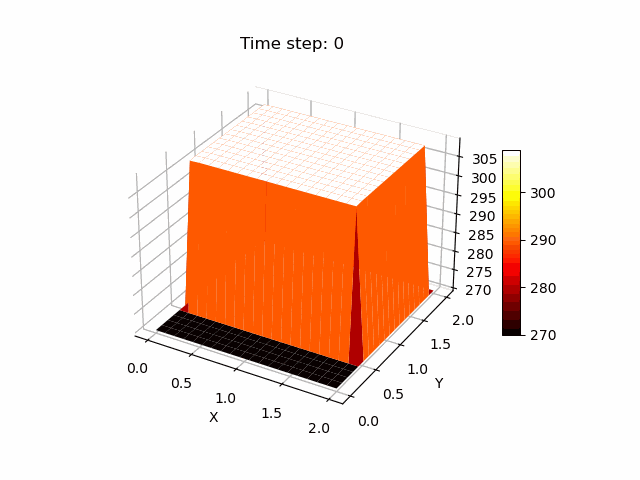

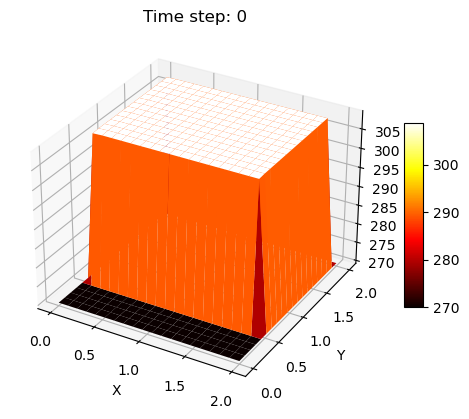

In [7]:
try:
    import cupy as cp
    using_cupy = True
except:
    import numpy as cp
    using_cupy = False
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from tqdm import tqdm

# Parameters for the 3D grid
Lx, Ly, Lz = 2.0, 2.0, 0.2  # Dimensions of the 3D grid (with Lz being smaller)
Nx, Ny, Nz = 20, 20, 20  # Number of points in x, y, and z directions (two layers in z)
dx, dy, dz = Lx / (Nx - 1), Ly / (Ny - 1), Lz / (Nz - 1)  # Step sizes
alpha1 = 0.3  # Thermal diffusivity for areas with zero in the matrix
alpha2 = 3.0  # Thermal diffusivity for areas with one in the matrix
beta = 0.005  # Convection coefficient
sigma = 5.67e-8  # Stefan-Boltzmann constant for radiation
epsilon = 0.85

T_ambient = 270  # Ambient temperature for radiation term
T_laser = T_ambient + 40
T_amplitude = T_laser - T_ambient

snapshot_N = 60  # Number of snapshots to save
time_steps_between_snapshots = 100
dt = 0.001  # Time step size

Nt = time_steps_between_snapshots * snapshot_N  # Number of time steps

def rotate_90(matrix):
    # Step 1: Transpose the matrix
    transposed = np.transpose(matrix)
    
    # Step 2: Reverse the order of elements in each row
    rotated = np.array([row[::-1] for row in transposed])
    
    return rotated

# Define the diffusivity matrix for the 2D region
visual_matrix = np.array([[
    [0,1],
    [0,1]
]])

# Reverse each row (flip horizontally)

visual_matrix_swapped = visual_matrix.transpose(2, 1, 0)

diffusivity_matrix = visual_matrix

# Create the 3D grid
x = cp.linspace(0, Lx, Nx)
y = cp.linspace(0, Ly, Ny)
z = cp.linspace(0, Lz, Nz)
X, Y, Z = cp.meshgrid(x, y, z, indexing='ij')

# Initial temperature distribution
temperature = cp.zeros((Nx, Ny, Nz)) + T_ambient

# Function to create a rectangular mask
def get_rectangular_mask(center, lengths):
    mask = (abs(X - center[0]) < lengths[0]) & (abs(Y - center[1]) < lengths[1])
    return mask

# Function to create a circular mask
def get_circular_mask(center, radius):
    distance = (X - center[0])**2 + (Y - center[1])**2
    mask = distance <= radius**2
    return mask

def apply_gaussian_in_rectangular_mask(sigma_x=Lx/8, sigma_y=Ly/8, mu_x=Lx/2, mu_y=Ly/2):
    gaussian = T_amplitude * cp.exp(-((X - mu_x)**2 / (2 * sigma_x**2) + (Y - mu_y)**2 / (2 * sigma_y**2)))
    temperature = gaussian
    return temperature

def set_borders_to_ambient_nd(temperature):
    # Set the borders to T_ambient for all dimensions
    temperature[0, :, :] = T_ambient  # First slice in the x-direction
    temperature[-1, :, :] = T_ambient  # Last slice in the x-direction

    temperature[:, 0, :] = T_ambient  # First slice in the y-direction
    temperature[:, -1, :] = T_ambient  # Last slice in the y-direction

    temperature[:, :, 0] = T_ambient  # First slice in the z-direction
    temperature[:, :, -1] = T_ambient  # Last slice in the z-direction
    
    return temperature

temperature[x  > Lx/4] = T_laser

#print(f"{temperature=}")
#temperature_with_border=set_borders_to_ambient_nd(temperature)
#print(f"{temperature_with_border=}")

initial_dist = "none"

if initial_dist == "circle":
    temperature[get_circular_mask((Lx / 2, Ly / 2), (Ly / 3))] += T_amplitude
elif initial_dist == "square":
    temperature[get_rectangular_mask((Lx / 2, Ly / 2), (Ly / 4, Ly / 4))] += T_amplitude
elif initial_dist == "gaussian":
    temperature += apply_gaussian_in_rectangular_mask()



# Create alpha variable based on the diffusivity matrix
def create_alpha_variable(matrix):
    # Create a meshgrid for the 3D space (x, y, z)
    
    # Initialize the alpha array with the default value alpha1
    alpha = cp.full((Nx, Ny, Nz), alpha1)
    
    # Iterate over the matrix to apply diffusivity
    for x_index in range(matrix.shape[0]):  # Iterate over the z dimension
        for y_index in range(matrix.shape[1]):  # Iterate over the y dimension
            for z_index in range(matrix.shape[2]):  # Iterate over the x dimension
                if matrix[x_index, y_index, z_index] == 1:
                    # Define the range for this block in the x, y, z directions
                    x_start = x_index * Lx / matrix.shape[0]
                    x_end = (x_index + 1) * Lx / matrix.shape[0]
                    y_start = y_index * Ly / matrix.shape[1]
                    y_end = (y_index + 1) * Ly / matrix.shape[1]
                    z_start = z_index * Lz / matrix.shape[2]
                    z_end = (z_index + 1) * Lz / matrix.shape[2]
                    
                    # Create a mask for the region where alpha should be alpha2
                    mask = (X >= x_start) & (X <= x_end) & (Y >= y_start) & (Y <= y_end) & (Z >= z_start) & (Z <= z_end)
                    
                    # Apply alpha2 in the selected region
                    alpha[mask] = alpha2
    
    return alpha

alpha_variable = create_alpha_variable(diffusivity_matrix)

print(f"{alpha_variable=}")


def keep_temperature_in_range(temperature):
    mask = (temperature > T_laser * 1.1)
    temperature[mask] = T_laser
    mask = (temperature < T_ambient * 0.9)
    temperature[mask] = T_ambient
    return temperature

# Conduction term (now in 3D)
def conduction_term(alpha, temperature):
    dTdx = (cp.roll(temperature, +1, axis=0) - temperature) / dx
    dTdy = (cp.roll(temperature, +1, axis=1) - temperature) / dy
    dTdz = (cp.roll(temperature, +1, axis=2) - temperature) / dz
    return alpha * (dTdx + dTdy + dTdz)

# Convection term (simplified for 3D)
def convection_term(temperature):
    velocity = cp.array([beta, beta, beta])  # velocity in x, y, z directions
    dTdx = (cp.roll(temperature, -1, axis=0) - temperature) / dx
    dTdy = (cp.roll(temperature, -1, axis=1) - temperature) / dy
    dTdz = (cp.roll(temperature, -1, axis=2) - temperature) / dz
    return velocity[0] * dTdx+velocity[0] * dTdy+velocity[0] * dTdz  # Convection in the x-direction for simplicity

# Radiation term (Stefan-Boltzmann law)
def radiation_term(temperature):
    mask = (temperature > T_laser * 1.1)
    temperature[mask] = T_laser
    mask = (temperature < T_ambient * 0.9)
    temperature[mask] = T_ambient
    return -4 * epsilon * sigma * (temperature**4 - T_ambient**4)

# Source term (Gaussian or square)
def source_term(type="square"):
    source = cp.zeros((Nx, Ny, Nz))
    if type == "gaussian":
        mu_x = Lx / 2
        mu_y = Ly / 2
        sigma = 0.1 * Lx
        r = min(Lx, Ly) / 4
        distance_from_center = np.sqrt((X - mu_x)**2 + (Y - mu_y)**2)
        source[distance_from_center <= r] = 1
    return source

# Time-stepping loop
snapshots = []
alpha = alpha_variable  # Update alpha in case the diffusivity changes during the simulation

for t in tqdm(range(Nt)):
    #print(f"Start {temperature=}")
    temperature = set_borders_to_ambient_nd(temperature)
    temperature = keep_temperature_in_range(temperature)
    #alpha = alpha_variable  # Update alpha in case the diffusivity changes during the simulation
    conduction = conduction_term(alpha, temperature)
    convection = convection_term(temperature)
    radiation = radiation_term(temperature)
    source = source_term("square")  # Example source type
    
    contributions =  conduction # + source  + convection + radiation 
    temperature += dt * contributions
    temperature = set_borders_to_ambient_nd(temperature)
    
    #print(f"End {temperature=}")
    # Save snapshot for visualization
    if t % time_steps_between_snapshots == 0:
        snapshots.append(temperature[:, :, :].copy())  # Store 2D snapshot of the first layer for visualization

# print(f"{snapshots[0]=}")
# print(snapshots[0].shape)
# print(f"Shape of X: {X.shape}")  # Should print (12, 12)
# print(f"Shape of Y: {Y.shape}")  # Should print (12, 12)
# 3D Visualization of the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Create the 3D grid
x_vals = cp.linspace(0, Lx, Nx)
y_vals = cp.linspace(0, Ly, Ny)
X_plot, Y_plot = np.meshgrid(x_vals, y_vals)

Z_values = snapshots[0][:,:,1]
#print(Z_values)
surf = ax.plot_surface(X_plot, Y_plot, Z_values, cmap='hot')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

def update_3d_plot(frame):
    ax.clear()
    Z_values = snapshots[frame][:,:,1]
    #print(Z_values)
    surf = ax.plot_surface(X_plot, Y_plot, Z_values, cmap='hot')
    ax.set_title(f"Time step: {frame * time_steps_between_snapshots}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Temperature")
    
    #ax.set_zlim(T_ambient, T_laser)

ani = animation.FuncAnimation(fig, update_3d_plot, frames=len(snapshots), interval=150)
ani.save("heat_equation_3D_two_layers.gif", writer='imagemagick')

from IPython.display import Image

# Provide the file path to the local GIF
Image(filename='heat_equation_3D_two_layers.gif')